# Create a large cutout of coadded images

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact authors: Christina Williams, Melissa Graham <br>
Last verified to run: 2024-05-04 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container Size: Large <br>
Targeted learning level: Intermediate <br>

**Description:** Create a large custom `deepCoadd` cutout.

**Skills:** Identify tracts and patches and combine them into a large custom `deepCoadd` cutout.

**LSST Data Products:** deepCoadd_calexp

**Packages:** lsst.ip.diffim.GetTemplateTask

**Credit:** Thanks to Aline Chu for raising in the Rubin Community Forum the issue of how to create patch- and tract-spanning cutouts. Thanks to Gregory Dubois-Felsmann and Lauren MacArthur who helped in the Forum.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

At the moment, the image cutout service demonstrated in DP0.2 tutorial notebook
13a must be passed a tract and patch, and can only create a cutout from a single
patch.

This will always be a contraint for single processed visit images (PVIs,
also known as `calexp`s).
In the future, users will be able to request `deepCoadd` cutouts from the 
Rubin image cutout service which span patch and tract boundaries.

In the meantime, this tutorial demonstrates how to use the `GetTemplateTask`
to create a single cutout image with contributions from multiple adjacent
patches and tracts. 

In the LSST Science Pipelines, `GetTemplateTask` is used to create a template
image from `deepCoadd` images for a given PVI, in order to perform Difference Image Analysis.

As described in the documentation for
<a href="https://pipelines.lsst.io/modules/lsst.ip.diffim/tasks/lsst.ip.diffim.GetTemplateTask.html">GetTemplateTask</a>
and its
<a href="https://pipelines.lsst.io/py-api/lsst.ip.diffim.GetTemplateTask.html#lsst.ip.diffim.GetTemplateTask.run">run method</a>,
the function of this task is to:

> *Build a template from existing coadds, which may span multiple tracts. The assembled template inherits the WCS of the selected skymap tract and the resolution of the template exposures. Overlapping box regions of the input template patches are pixel by pixel copied into the assembled template image. There is no warping or pixel resampling. Pixels with no overlap of any available input patches are set to nan value and NO_DATA flagged.*

>*Where the tracts overlap, the resulting template image is averaged. The PSF on the template is created by combining the CoaddPsf on each template image into a meta-CoaddPsf.*

**Related tutorials:**
This tutorial assumes some familiarity with the following concepts.
DP0.2 tutorial notebooks that demonstrate these concepts more fully are listed in parentheses.
It is not necessary to run through all of these other tutorials before doing this one,
but they might be useful as reference.

 * the butler (04a, 04b)
 * the TAP service (02)
 * image display (03a, 03b)

### 1.1. Import packages

Import packages from the LSST Science Pipelines (top) and 
general python packages (bottom).

In [1]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.rsp import get_tap_service, retrieve_query
from lsst.daf.butler import Butler, CollectionType
from lsst.ip.diffim import GetTemplateTask
from lsst.afw.image import Image

import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

# Added CCW to sanity check WCS
from photutils.aperture import SkyCircularAperture
from astropy import units as u
from astropy.coordinates import SkyCoord


### 1.2. Define functions and parameters

Set the `afwDisplay` backend to `matplotlib`.

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

Instantiate the TAP service.

In [3]:
service = get_tap_service("tap")

Instantiate the butler.

In [4]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

## 2. Prepare to create the cutout

### 2.1. Define central coordinates and box size

Define the central coordinates and the size of the side of the desired cutout.

For this example, the coordinates 50.5265, -39.7589 are known to be near the intersection of patches and tracts.

The size of the cutout will be constrained by the container size selected
when the Notebook Aspect session was started, because all the images
that contribute to the cutout must be held in memory simultaneously
and passed to `GetTemplateTask` (this will become clear in Section 3).

In [5]:
my_ra = 50.5265
my_dec = -39.7589
box_side_deg = 0.2

Define the extent of the cutout in RA and Dec. Include the `cos(dec)` factor.

In [6]:
ra1 = my_ra + 0.5 * box_side_deg / np.cos(np.radians(my_dec))
ra2 = my_ra - 0.5 * box_side_deg / np.cos(np.radians(my_dec))
dec1 = my_dec - 0.5 * box_side_deg
dec2 = my_dec + 0.5 * box_side_deg
print('ra1 = %8.4f,  ra2 = %8.4f,  delta RA = %6.3f' %
      (ra1, ra2, np.abs(ra2-ra1)))
print('dec1 = %8.4f, dec2 = %8.4f, delta Dec = %6.3f' %
      (dec1, dec2, np.abs(dec2-dec1)))

ra1 =  50.6566,  ra2 =  50.3964,  delta RA =  0.260
dec1 = -39.8589, dec2 = -39.6589, delta Dec =  0.200


Define corners of the cutout.

The order is: SE, SW, NW, NE, as drawn in the plot above.

In [7]:
corners = np.asarray([[ra1, dec1], [ra2, dec1],
                      [ra2, dec2], [ra1, dec2]],
                     dtype='float')

Option to create a little plot to visualize the corners.

Note that the figure is forced to 3:2 dimensions size.

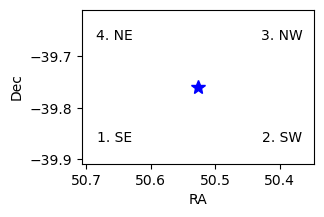

In [8]:
fig = plt.figure(figsize=(3, 2))
plt.plot(my_ra, my_dec, '*', ms=10, color='blue')
clabels = ['1. SE', '2. SW', '3. NW', '4. NE']
for corner, clabel in zip(corners, clabels):
    plt.text(corner[0], corner[1], clabel, ha='center', va='center')
plt.gca().invert_xaxis()
plt.xlim([ra1+0.05, ra2-0.05])
plt.ylim([dec1-0.05, dec2+0.05])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

### 2.2. Identify nearest patch to use as anchor image

Use the butler to find the tract and patch within which
the central coordinates of the desired cutouts are most centered.

This will be the tract and patch used as the "anchor image"
when creating the big cutout.

In [9]:
my_point = geom.SpherePoint(my_ra * geom.degrees,
                            my_dec * geom.degrees)
skymap = butler.get('skyMap')
tract = skymap.findTract(my_point)
patch = tract.findPatch(my_point)
anchor_tract = tract.tract_id
anchor_patch = patch.getSequentialIndex()
print('anchor tract and patch: ', anchor_tract, anchor_patch)
del my_point, skymap, tract, patch

anchor tract and patch:  3442 13


### 2.3. Identify additional tracts and patches

In the future, it will be possible to write ADQL statements
that use the INTERSECTS functionality to identify all patches
(or images) that overlap with a defined polygon.

For now, use the TAP service to search the `coaddPatches` table
for images with central coordinates that indicate the patch
could *potentially* overlap with the defined extent of the 
desired cutout.

Increase the extent of the search by the patch size to make sure
no overlapping patch is missed.
This may well end up identifying a few patches that do not, in the end,
overlap with the extent of the desired cutout -- and that's ok.

In [10]:
sra1 = ra1 + 0.22
sra2 = ra2 - 0.22
sdec1 = dec1 - 0.22
sdec2 = dec2 + 0.22

scorners = np.asarray([[sra1, sdec1], [sra2, sdec1],
                       [sra2, sdec2], [sra1, sdec2]],
                      dtype='float')

Create the TAP query.

In [11]:
string_polygon = ""
for c, scorner in enumerate(scorners):
    s1 = str(np.round(scorner[0], 4))
    s2 = str(np.round(scorner[1], 4))
    string_polygon += s1 + ', ' + s2
    if c < 3:
        string_polygon += ', '
    del s1, s2

query = "SELECT lsst_patch,lsst_tract,s_dec,s_ra "\
        "FROM dp02_dc2_catalogs.CoaddPatches "\
        "WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), "\
        "POLYGON('ICRS', "+string_polygon+"))=1"
print(query)

SELECT lsst_patch,lsst_tract,s_dec,s_ra FROM dp02_dc2_catalogs.CoaddPatches WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), POLYGON('ICRS', 50.8766, -40.0789, 50.1764, -40.0789, 50.1764, -39.4389, 50.8766, -39.4389))=1


Run the TAP query.

In [12]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


If the returned job phase was "error", uncomment the following to review the error.

In [13]:
# job.raise_if_error()

Retrieve the TAP results.

In [14]:
results = job.fetch_result().to_table()

Option to show the results.

In [15]:
# results

Hold the tract and patch values for images that 
will contribute, in addition to the anchor image,
to the final custom cutout in `add_tracts_and_patches`.

In [16]:
temp = []
for result in results:
    tract = result['lsst_tract']
    patch = result['lsst_patch']
    if (tract != anchor_tract) | (patch != anchor_patch):
        temp.append([tract, patch])
add_tracts_and_patches = np.asarray(temp, dtype='int')
del temp

print('add these to the anchor patch: ')
print(add_tracts_and_patches)

add these to the anchor patch: 
[[3442   19]
 [3441    7]
 [3441   14]
 [3442   20]
 [3442   12]]


## 3. Create the custom cutout

Define the filter of the desired custom cutout.

In [17]:
use_filter = 'r'

Define the `dataId` for the anchor image.

Use the butler to retrieve the anchor image and its World Coordinate System (WCS).

In [18]:
anchor_dataId = {'tract': anchor_tract, 'patch': anchor_patch,
                 'band': use_filter}
anchor_image = butler.get('deepCoadd_calexp', dataId=anchor_dataId)
anchor_wcs = butler.get('deepCoadd_calexp.wcs', dataId=anchor_dataId)

Visually inspect the `anchor_image`. The below demonstration plots a circle centered at `my_ra` and `my_dec`, with diameter equal to the desired image box edge outlined above. The map indicates that the desired location is near the patch and tract edge and joining to other deepCoadds is required in order to display a contiguous image. 

(<matplotlib.patches.Circle at 0x7f1dc5667ed0>,)

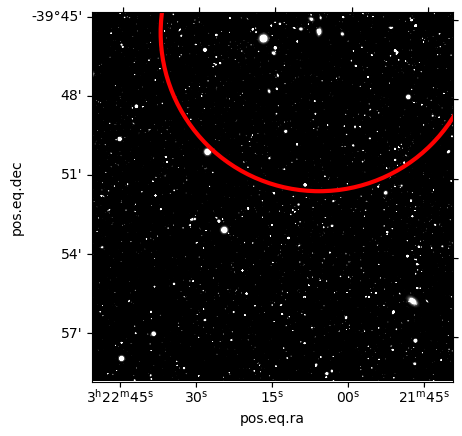

In [33]:
radius = box_side_deg/2. * u.deg
coord = SkyCoord(ra=my_ra*u.degree, dec=my_dec*u.degree, frame='icrs')

wcs = WCS(anchor_image.getWcs().getFitsMetadata())
plt.subplot(projection=WCS(anchor_image.getWcs().getFitsMetadata()))
extent = (anchor_image.getBBox().beginX, anchor_image.getBBox().endX,
                 anchor_image.getBBox().beginY, anchor_image.getBBox().endY)

plt.imshow(anchor_image.image.array,vmin=.1,vmax=1,extent=extent, origin='lower',cmap='gray')

aperture = SkyCircularAperture(coord, r=radius)
pix_aperture = aperture.to_pixel(wcs)
pix_aperture.plot(color='r',lw=3)


Create a bounding box for the new image using the anchor image's WCS.

In [20]:
corner_SE_deg = geom.SpherePoint(corners[0][0], corners[0][1], geom.degrees)
corner_NW_deg = geom.SpherePoint(corners[2][0], corners[2][1], geom.degrees)
corner_SE_pix = anchor_wcs.skyToPixel(corner_SE_deg)
corner_NW_pix = anchor_wcs.skyToPixel(corner_NW_deg)

xmin = int(np.floor(corner_SE_pix[0]))
ymin = int(np.floor(corner_SE_pix[1]))
xmax = int(np.floor(corner_NW_pix[0]))
ymax = int(np.floor(corner_NW_pix[1]))

new_img = Image(geom.Box2I(minimum=geom.Point2I(x=xmin, y=ymin),
                           maximum=geom.Point2I(x=xmax, y=ymax)),
                dtype=np.float32)
new_img_bbox = new_img.getBBox()
print(new_img_bbox)

del corner_SE_deg, corner_NW_deg, corner_SE_pix, corner_NW_pix
del xmin, ymin, xmax, ymax
del new_img

(minimum=(24666, 6079), maximum=(28302, 9643))


Create the arrays of `dataId`s and images to be passed to `GetTemplateTask`.

In [21]:
all_dataIds = [anchor_dataId]
all_images = [anchor_image]
for i in range(len(add_tracts_and_patches)):
    temp_tract = add_tracts_and_patches[i][0]
    temp_patch = add_tracts_and_patches[i][1]
    temp_dataId = {'tract': temp_tract, 'patch': temp_patch,
                   'band': use_filter}
    temp_image = butler.get('deepCoadd_calexp', dataId=temp_dataId)
    all_images.append(temp_image)
    all_dataIds.append(temp_dataId)
    del temp_tract, temp_patch, temp_dataId, temp_image

Option to print the `dataId`s.

In [22]:
for dataId in all_dataIds:
    print(dataId)

{'tract': 3442, 'patch': 13, 'band': 'r'}
{'tract': 3442, 'patch': 19, 'band': 'r'}
{'tract': 3441, 'patch': 7, 'band': 'r'}
{'tract': 3441, 'patch': 14, 'band': 'r'}
{'tract': 3442, 'patch': 20, 'band': 'r'}
{'tract': 3442, 'patch': 12, 'band': 'r'}


Define `getTemplateTask`. 

No configuration changes are needed.

In [23]:
getTemplateTask = GetTemplateTask()

Create the custom cutout as `newimage`.

>**Notice:** Some input patch images might be skipped for not, in the end, overlapping with the defined bounding box after all. This was expected, as described in Section 2.3. 

In [24]:
newimage = getTemplateTask.run(all_images, new_img_bbox,
                               anchor_wcs, all_dataIds)

## 4. Visualize the custom cutout

Extract metadata for the custom cutout.

In [25]:
newimage_wcs = newimage.template.getWcs()
newimage_wcs_fmd = newimage.template.getWcs().getFitsMetadata()
newimage_bbox = newimage.template.getBBox()
newimage_extent = (newimage_bbox.beginX, newimage_bbox.endX,
                   newimage_bbox.beginY, newimage_bbox.endY)

### 4.1. Display with matplotlib

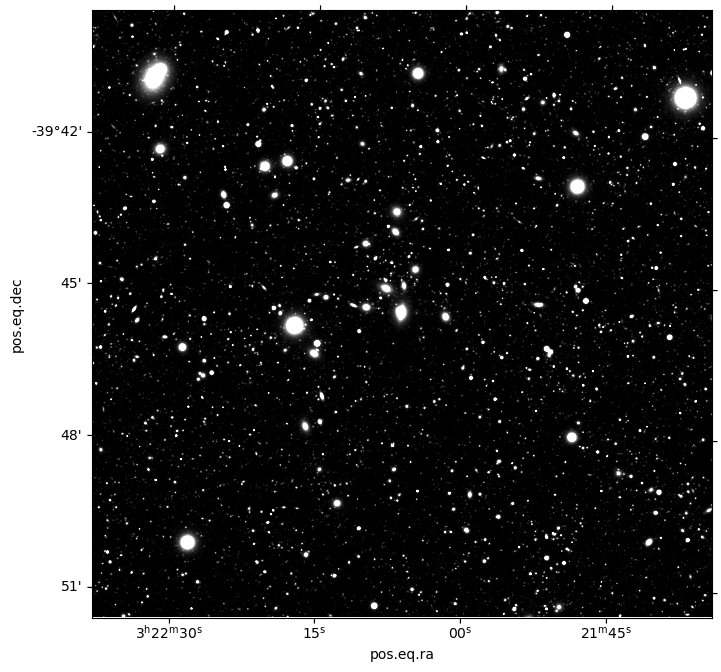

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(projection=WCS(newimage_wcs_fmd))
plt.imshow(newimage.template.image.array, vmin=0.01, vmax=0.5,
           extent=newimage_extent, origin='lower', cmap='gray')
plt.show()

### 4.2. Display with `afwDisplay`

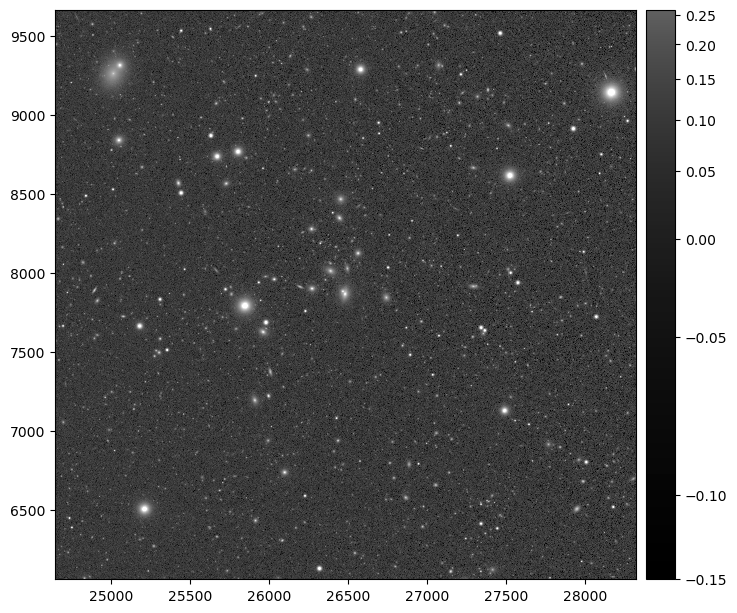

In [27]:
fig = plt.figure(figsize=(8, 8))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(newimage.template.image)
plt.show()

### 4.3. Display with Firefly

Firefly allows for interactive image display and manipulation.
See DP0.2 tutorial notebook 03b for a full demonstration of how to use Firefly within the Notebook Aspect.

Reset the `afwDisplay` backend to be Firefly and start the display.
A new tab will open, containing the Firefly interface.

In [28]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

Display the image in Firely.

In [29]:
afw_display.mtv(newimage.template)

The Firefly default is to visualize the mask plane with colors. 
Set the mask plane transparency to 100, fully transparent, to see only the pixel data.

In [30]:
afw_display.setMaskTransparency(100)

### 4.4. Option to save as a FITS file

Save as a FITS file in the home directory.

> **Warning:** Images can take up a lot of disk space. Save and download with caution.

In [31]:
username = os.environ.get('USER')
fnm = '/home/' + username + '/my_big_cutout.fits'
newimage.template.writeFits(fnm)
del username, fnm